# Introduction to Machine Learning
## Project Phase 1

Sina Fathi | 402111261

Seyyed Amirmahdi Sadrzadeh | 401102015

### Part 1: Data Preproccessing

First we import the needed libraries:

In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

Now we use torch library to load the MNIST dataset and then turn them to numpy arrays:

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)

X_train_torch = trainset.data
Y_train_torch = trainset.targets

X_train = X_train_torch.numpy()
Y_train = Y_train_torch.numpy()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.28MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 155kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.27MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



To use the datas, we binarize them by setting a threshold equal to 128. So all pixels with values higher than 128 will be set to 1 and others will be set to 0. We also flatten the datas to use them in our model:

In [4]:
threshold = 128
X_train = (X_train > threshold).astype(np.uint32)
X_train_binary = X_train.reshape(-1, 28 * 28)

The plot to show the samples:

In [5]:
def show_samples(samples, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].reshape(28, 28), cmap='binary')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

And now we use the above function to show 10 samples from the dataset:

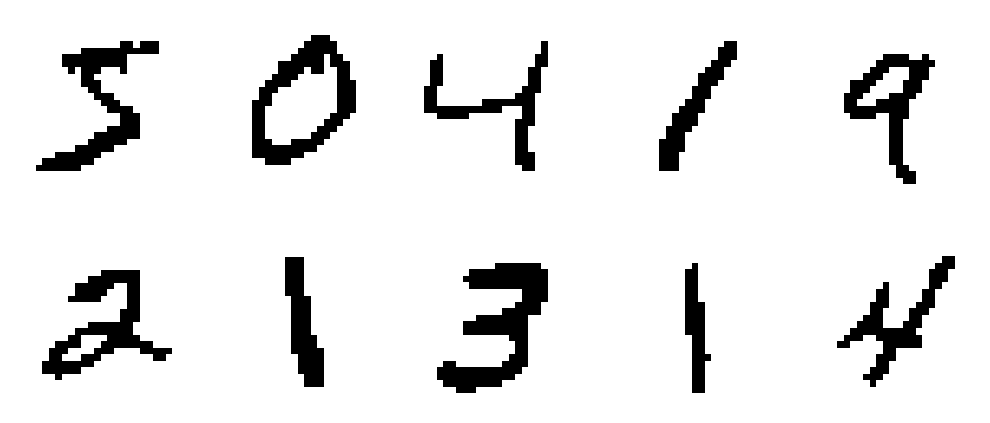

In [6]:
show_samples(X_train_binary[:10])

### Part 2: Implementing the model

To implement the RBM class, we initialize the values of the model parameters by setting the number of layers, the learning rate , and weights and biases. We set the initial values of biases to zero and set the initial values of the weights to a small value using gaussian distribution.

For the contstrative divergence, we use the algorythm in the theory part and implement the method accordingly.

The other part are like the classes we have implemented before.

You can see the RBM class below:

In [52]:
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.W = np.random.normal(0, 0.05, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (np.random.uniform(size=prob.shape) < prob).astype(np.int32)

    def gibbs_sampling(self, h_sample):
        v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
        v = self.sample(v_prob)
        return v

    def contrastive_divergence(self, v, k):

      h_prob_0 = self.sigmoid(np.dot(v, self.W) + self.h_bias)
      h_sample_0 = self.sample(h_prob_0)

      v_neg = v.copy()

      for _ in range(k):
          h_prob = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
          h_sample = self.sample(h_prob)
          v_prob_neg = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
          v_neg = self.sample(v_prob_neg)

      h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)

      positive_grad = np.dot(v.T, h_prob_0)
      negative_grad = np.dot(v_neg.T, h_prob_neg)

      batch_size = v.shape[0]
      self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
      self.v_bias += self.learning_rate * np.mean(v - v_neg, axis=0)
      self.h_bias += self.learning_rate * np.mean(h_prob_0 - h_prob_neg, axis=0)

      return v_neg


    def train(self, data, epochs=10, k=1, batch_size=64):
        for epoch in range(epochs):
            np.random.shuffle(data)
            epoch_loss = 0
            for batch_start in range(0, len(data), batch_size):
                batch = data[batch_start:batch_start + batch_size]
                v_neg = self.contrastive_divergence(batch, k)
                epoch_loss += np.mean((batch - v_neg) ** 2)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data):.5f}")

    def generate_samples(self, n_samples=10):
        samples = []
        for i in range(n_samples):
          sample = np.random.binomial(1, 0.5, self.n_hidden)
          sample = self.gibbs_sampling(sample)
          samples.append(sample)
        return np.array(samples)

Now that we have completely implemented the class, we use the code below to train the model.

You can see the loss of each epoch and how the model converges for different values of k (1, 5, 10).

In [53]:
n_visible = X_train_binary.shape[1]
n_hidden = 64
k_values = [1, 5, 15]
rbms = {}

for k in k_values:
    print(f"Training RBM with k={k}")
    rbm = RBM(n_visible, n_hidden)
    rbm.train(X_train_binary, epochs=10, k=k)
    rbms[k] = rbm

Training RBM with k=1
Epoch 1/10, Loss: 0.00174
Epoch 2/10, Loss: 0.00134
Epoch 3/10, Loss: 0.00124
Epoch 4/10, Loss: 0.00119
Epoch 5/10, Loss: 0.00115
Epoch 6/10, Loss: 0.00113
Epoch 7/10, Loss: 0.00111
Epoch 8/10, Loss: 0.00110
Epoch 9/10, Loss: 0.00108
Epoch 10/10, Loss: 0.00107
Training RBM with k=5
Epoch 1/10, Loss: 0.00205
Epoch 2/10, Loss: 0.00157
Epoch 3/10, Loss: 0.00146
Epoch 4/10, Loss: 0.00139
Epoch 5/10, Loss: 0.00135
Epoch 6/10, Loss: 0.00132
Epoch 7/10, Loss: 0.00129
Epoch 8/10, Loss: 0.00127
Epoch 9/10, Loss: 0.00125
Epoch 10/10, Loss: 0.00124
Training RBM with k=15
Epoch 1/10, Loss: 0.00230
Epoch 2/10, Loss: 0.00176
Epoch 3/10, Loss: 0.00165
Epoch 4/10, Loss: 0.00158
Epoch 5/10, Loss: 0.00153
Epoch 6/10, Loss: 0.00150
Epoch 7/10, Loss: 0.00147
Epoch 8/10, Loss: 0.00145
Epoch 9/10, Loss: 0.00142
Epoch 10/10, Loss: 0.00141


Now to see the generated samples of the model, we use the function below:

In [16]:
def show_generated_samples(rbm, k, n_samples=10):
    print(f"Generated samples for k={k}")
    samples = rbm.generate_samples(n_samples)
    samples = samples.reshape((-1, 28, 28))
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap='binary')
        ax.axis('off')
    plt.show()

In [1]:
for k in k_values:
    show_generated_samples(rbms[k],k)

NameError: name 'k_values' is not defined

We can see that by increasing the value of k, the numbers generated become much more clear.

### Part 3: Showing the sampling proccess


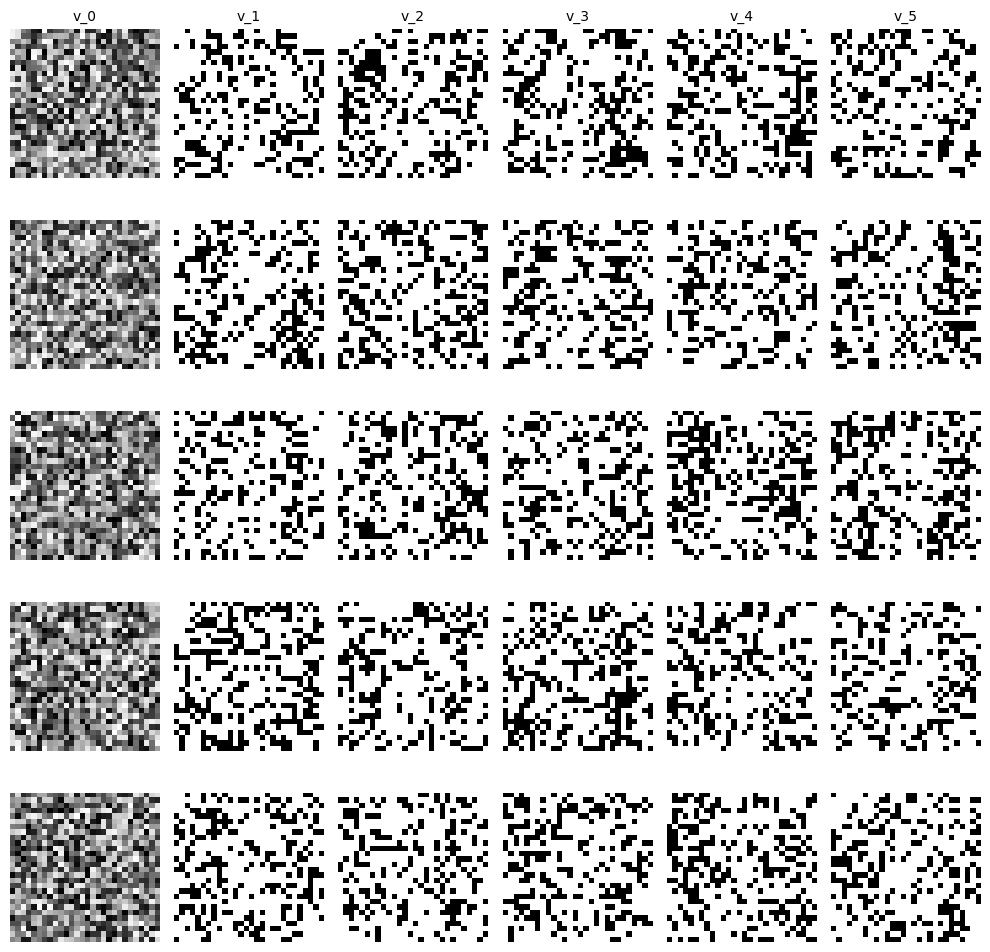

In [56]:
def visualize_mcmc_process(rbm, n_samples=5, k=5):
    """
    Visualize the MCMC process in RBM (v_0, v_1, ..., v_k).
    """
    samples = np.random.rand(n_samples, rbm.n_visible)  # Random initialization
    process = [samples]  # Store intermediate states

    # Perform Gibbs sampling for k steps and store each step
    for _ in range(k):
        h_prob = rbm.sigmoid(np.dot(samples, rbm.W) + rbm.h_bias)
        h_sample = rbm.sample(h_prob)
        v_prob = rbm.sigmoid(np.dot(h_sample, rbm.W.T) + rbm.v_bias)
        samples = rbm.sample(v_prob)
        process.append(samples)

    # Visualize the process for each sample
    fig, axes = plt.subplots(n_samples, k + 1, figsize=(10, n_samples * 2))
    for i in range(n_samples):
        for j in range(k + 1):
            ax = axes[i, j] if n_samples > 1 else axes[j]
            ax.imshow(process[j][i].reshape(28, 28), cmap='binary')
            ax.axis('off')
            if i == 0:
                ax.set_title(f"v_{j}", fontsize=10)
    plt.tight_layout()
    plt.show()

# Visualize the MCMC process for k=5 with the trained RBM (k=1)
visualize_mcmc_process(rbms[1], n_samples=5, k=5)

Q_4

In [59]:
class ConditionalRBM(RBM):
    def __init__(self, n_visible, n_hidden, n_classes):
        super().__init__(n_visible + n_classes, n_hidden)
        self.n_classes = n_classes

    def train(self, data, labels, epochs=10, k=1, lr=0.01, batch_size=64):
        data_with_labels = np.hstack([data, labels])  # Append class labels
        super().train(data_with_labels, epochs, k, batch_size)

    def generate_samples(self, target_label, n_samples=10, k=1):
        # Initialize samples and set target label
        samples = np.random.rand(n_samples, self.n_visible)
        labels = np.zeros((n_samples, self.n_classes))
        labels[np.arange(n_samples), target_label] = 1
        samples_with_labels = np.hstack([samples, labels])

        # Perform Gibbs sampling
        generated = self.gibbs_sampling(samples_with_labels, k)
        return generated[:, :-self.n_classes]  # Return only the visible units

# Prepare one-hot encoded labels
n_classes = 10
y_train_one_hot = np.eye(n_classes)[Y_train]  # Convert labels to one-hot

# Train a conditional RBM
conditional_rbm = ConditionalRBM(n_visible, n_hidden, n_classes)
print("Training Conditional RBM...")
conditional_rbm.train(X_train_binary, y_train_one_hot, epochs=5, k=1, lr=0.1, batch_size=64)

# Generate samples for specific digits
target_digits = [0, 1]  # Digits to generate
for digit in target_digits:
    print(f"Generated samples for digit {digit}:")
    generated_samples = conditional_rbm.generate_samples(target_label=digit, n_samples=5, k=5)
    generated_samples = generated_samples.reshape((-1, 28, 28))
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(generated_samples[i], cmap='binary')
        ax.axis('off')
    plt.show()

Training Conditional RBM...
Epoch 1/5, Loss: 0.0017
Epoch 2/5, Loss: 0.0013
Epoch 3/5, Loss: 0.0013
Epoch 4/5, Loss: 0.0012
Epoch 5/5, Loss: 0.0012
Generated samples for digit 0:


ValueError: shapes (5,804) and (794,64) not aligned: 804 (dim 1) != 794 (dim 0)